In [6]:
#%%
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchgeometry.losses import dice
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score
import pandas as pd
import skimage.io as io
import seaborn as sns
# custom modules
import data
import model
import train
import augmentation
#%% set up
root_dir = './EM_ISBI_Challenge/'
batch_size = 32

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using cuda')
else:
    device = torch.device('cpu')
    print('Using cpu')

sns.set(style='white',font_scale=1.5)


Using cpu


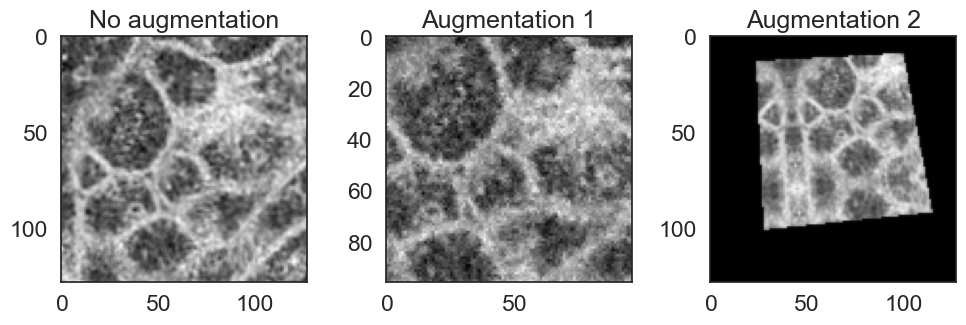

In [7]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
titles=['No augmentation', 'Augmentation 1', 'Augmentation 2']
for i, (img_trans, lab_trans) in enumerate(zip(augmentation.IMG_TRANS, augmentation.LAB_TRANS)):
    data_train = data.DataHandler(
        root_dir=root_dir,
        subset='train',
        return_patches=True,
        img_trans=img_trans,
        lab_trans=lab_trans)
    torch.manual_seed(123)
    train_data, valid_data = torch.utils.data.random_split(data_train, (0.8, 0.2))
    train_loader = DataLoader(dataset = train_data,
                            batch_size = batch_size,
                            shuffle = False,
                            num_workers = 0)
    valid_loader = DataLoader(dataset = valid_data,
                            batch_size = batch_size,
                            shuffle = False,
                            num_workers = 0)
    img, lab = next(iter(train_loader))
    one_img = img[10,0,:,:].detach().numpy()
    ax[i].imshow(one_img, cmap='gray')
    ax[i].set_title(titles[i])
plt.tight_layout()
plt.show()

In [67]:
img, lab = next(iter(train_loader))

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

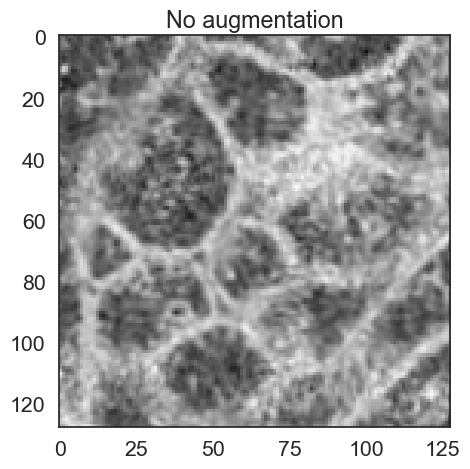

In [68]:
import skimage.io as io
import seaborn as sns
sns.set(style='white', font_scale=1.4)
one_img = img[10,0,:,:].detach().numpy()
io.imshow(one_img, cmap='gray')
plt.title('No augmentation')
cb = plt.colorbar() 
cb.remove() 
plt.savefig('test01.png') 

In [ ]:
io.imshow(lab)

In [ ]:
#%%
import torch
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
# custom modules
import data
import model
import train
import augmentation
#%% set up
root_dir = './EM_ISBI_Challenge/'
# BATCH_SIZE = [32,64]
batch_size = 32
LR = [1e-3, 1e-4, 1e-5]
epochs = 10
NUM_CHANNELS = [16,32,64]

#%%
for i, (img_trans, lab_trans) in tqdm(enumerate(zip(augmentation.IMG_TRANS[1:], augmentation.LAB_TRANS[1:])), desc='trans', position=0):
    data_train = data.DataHandler(
        root_dir=root_dir,
        subset='train',
        return_patches=True,
        img_trans=img_trans,
        lab_trans=lab_trans)
    torch.manual_seed(123)
    train_data, valid_data = torch.utils.data.random_split(data_train, (0.8, 0.2))
    train_loader = DataLoader(dataset = train_data,
                            batch_size = batch_size,
                            shuffle = False,
                            num_workers = 0)
    valid_loader = DataLoader(dataset = valid_data,
                            batch_size = batch_size,
                            shuffle = False,
                            num_workers = 0)
    for lr in tqdm(LR, desc="lr", position=1):
        for num_channels in tqdm(NUM_CHANNELS, desc="ch", position=2):
            net = model.UNet(num_channels)
            loss_function = torch.nn.BCELoss()
            optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)

            net, output = train.train_validation_loop(net, train_loader, valid_loader, epochs, optimizer, loss_function)
            output_pd = pd.DataFrame(output)
            output_pd.to_csv(f'results/results_{i+2}_trans_{num_channels}_ch_{lr:.0e}_lr.csv', index=False)
# %%
